In [118]:
import numpy as np
import json
import os
import glob
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns


In [119]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [120]:
def load_data(idx: int):
    max_idx = len(os.listdir('./Source/img/'))
    assert idx < max_idx, 'idx is greater than the number of files'

    img = cv.imread('./Source/img/img_' + f'{idx}'.zfill(6) + '.jpeg')
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    with open('./Source/mask/img_' + f'{idx}'.zfill(6) + '.json', 'r') as f:
        label = json.load(f)

    depth = cv.imread('./Source/depth/img_' + f'{idx}'.zfill(6) + '.jpeg')
    depth = cv.cvtColor(depth, cv.COLOR_BGR2RGB)

    rle_strings = [str(label['annotations'][i]['segmentation'])[1:-1].replace(', ', ' ') for i in range(len(label['annotations']))]

    masks = [rle_decode(rle_string, (label['images'][0]['height'], label['images'][0]['width'])) for rle_string in rle_strings]
    if len(masks) != 0:
        ids = [annotation['id'] for annotation in label['annotations']]
        final_mask = np.zeros(masks[0].shape)
        for i in range(0, len(masks)):
            final_mask += masks[i] * ids[i]
        bboxes = np.array([instance_annotation['bbox'] for instance_annotation in label['annotations']])

    else:
        final_mask = np.zeros(img.shape[:2])

    bboxes = np.array([instance_annotation['bbox'] for instance_annotation in label['annotations']])

    return img, final_mask, depth, bboxes

In [121]:
img, mask, depth, bboxes = load_data(31)

In [122]:
def vis(img: np.ndarray, mask: np.ndarray, depth: np.ndarray, bboxes: np.ndarray):
    fig, ax = plt.subplots(1, 4, figsize=(12,54))
    ax[0].imshow(img)
    bboxes_img = img.copy()
    for bbox in bboxes:
        cv.rectangle(bboxes_img, bbox[:2], bbox[2:], (255, 0, 0), 1)
    ax[1].imshow(bboxes_img)

    palette = np.round(255 * np.array(sns.color_palette("husl", 16)))
    palette[0] = np.zeros(3)
    colored_mask = np.zeros((*mask.shape, 3), dtype='uint8')
    for i in range(colored_mask.shape[0]):
        for j in range(colored_mask.shape[1]):
            colored_mask[i, j] = palette[int(mask[i, j])]
    ax[2].imshow(colored_mask)
    ax[3].imshow(depth)

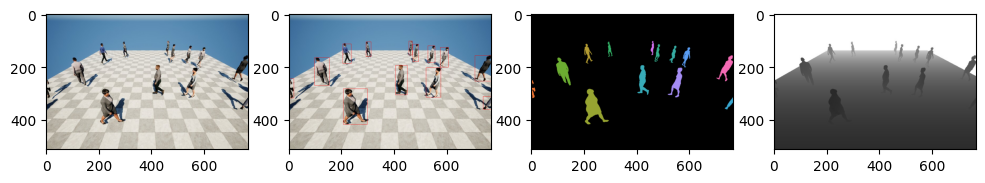

In [123]:
vis(img, mask, depth, bboxes)